### Terms

* Random Variables `pyro.sample`
* Observed Random Variables `pyro.sample`
* Parameters (non-random) variables (e.g. learning rate) `pyro.param` they can also be variational parameters.

#### Example Linear Regression

This is the ruggness in afric example given in stat. rethinking. Note we are first doing non-Bayesian linear regression.

Taken from https://pyro.ai/examples/intro_long.html#Example:-Geography-and-national-income

In [2]:
import pyro
from pyro.distributions import LogNormal, Categorical, MultivariateNormal, Normal
import torch
import pyro.poutine as poutine
import pyro
import pyro.distributions as dist
import pandas as pd
import numpy as np

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [4]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


In [5]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

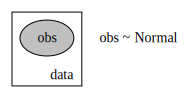

In [6]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(())) #We initialize with random
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

### Sampling or posterior evaluation

Calling the simple_model without an argument, finally calls

```
 return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```

If `log_gdp=None` than a sample is drawn. Therefore, you get different results for the two calls below

In [7]:
simple_model(is_cont_africa, ruggedness)[0:3],simple_model(is_cont_africa, ruggedness)[0:3]

(tensor([-1.0897,  0.0681, -2.6433], grad_fn=<SliceBackward0>),
 tensor([-2.4185, -2.2740, -0.9579], grad_fn=<SliceBackward0>))

In [8]:
simple_model(is_cont_africa, ruggedness, log_gdp)[0:3],simple_model(is_cont_africa, ruggedness, log_gdp)[0:3] #Calcluates the posterior

(tensor([7.4926, 8.2169, 9.9333]), tensor([7.4926, 8.2169, 9.9333]))

### Persistence of parameters

The parameters are values that need to be updated by an external optimization or so. Therefore they are stored in a central place and
`pyro.param` values persist across model calls, unless the parameter store is updated by an optimization algorithm or cleared via `pyro.clear_param_store()`.


In [9]:
pyro.get_param_store().get_param('bA'),pyro.get_param_store().get_param('bA')

(tensor(-0.4425, requires_grad=True), tensor(-0.4425, requires_grad=True))

### The plate statement

Think of plates as for loops. But internaly pyro uses thinks like broadcasting happens for parallel excecution and the stuff is fast as hell.

### Going Bayesian
Just replace the parameters with